# Predicting Sale Prices for Ames Iowa Housing Dataset... For Evil

#### By: Brandon Greenspan: [LinkedIn](https://https://www.linkedin.com/in/brandonlgreenspan)

### Table of Contents:
- [Problem Statement](#Problem-Statement)
- [Executive Summary](#Executive-Summary)
- [Loading Data](#Loading-Data)
- [Data Cleaning](#Data-Cleaning)
- [EDA](#EDA)
- [Model Preparation](#Model-Preparation)
- [Modeling](#Modeling)
    - [Baseline Model](#Baseline-Model)
    - [Linear Regression](#Linear-Regression)
    - [Ridge Model](#Ridge)
    - [Lasso Model](#Lasso)
    - [Improved Linear Regression](#Improved-Linear-Regression-By-Eliminating-Zero-Coefficients)
- [Model Selection](#Model-Selection)
- [Model Evaluation](#Model-Evaluation)
- [Conclusion](#Conclusion)
    - [Recommendations](#Recommendations)
    - [Future Steps](#Future-Steps)
- [References](#References)


## Problem Statement

Dr. Evil needs to build a new lair, and since Iowa State has the best Evil Communications school in the country, he chose Ames, IA for their workforce.
ONE MILLION DOLLARS doesn’t doesn’t run a freaking evil empire like it used to, ok?  We need to budget wisely, and that can’t all go to the house.
When Dr. Evil commandeers a house, he pays what he thinks is fair, so he wants me, his Number 3, to determine what fair is, and doesn’t want me to be wrong.  He’ll punish me if we pay more than $50,000 off from the actual value, making RMSE our metric because it is measured in the same unit as our predictive value.  I don’t want to be wrong and be very badly hurt.
All I had to make my predictions were data from the Ames Assessor’s Office on properties sold from 2006-2010.  This was collected by Dr. Dean De Cock at Truman State University.
Using a lasso regression, I take my evil features and do my best to minimize the predictive error.

## Executive Summary

Dr. Evil needs an evil lair and has decided to build it in Ames, IA in order to take advantage of the local workforce.  Iowa State is home to the most evil Communications program in the nation, which will make for good evil employees.

In order to best understand the housing market, the Evil Doctor, Doctor Evil, has assigned me, Number 3, to build a "model" that accurately predicts housing prices in Ames.  After loading in the data from Dr. De Cock (not an evil Doctor), I had a lot of evil cleaning to take care of.  Dr. Evil did not want me to eliminate any outliers because he did not want to eliminate any potential homes that might have had built-in "magma" chambers.  Even though, I informed him that it wasn't an option under the misc. category, he promptly reminded me of his evil credentials, and I obliged.  After filling in null values as zeros or "none" depending on the intended datatype, and changing ordinal categories to numerical values, EDA revealed the different features that already had a linear relationship with sale price.

We wouldn't be much of an established evil organization without good feature engineering practices.  While usually reserved for engineering evil animals like a lemhog (lemming * hog), we redesigned it to evil engineer features for our "model."  Rumor has it that Dr. Evil's father feature engineered the question mark.  A lot of our engineered features showed strong correlations to price, especially our "Evil Petting Zoo" feature which looked at high quality outdoor space which we interacted with Miami's area code (which is usually a predictor of success among evil bald men).  We started with a simple model of only 10 features, but when Dr. Evil learned that he doesn't pay extra for extra features, he wanted all of the freaking evil features in the "model," so we used all 242 to start.

Using the RMSE as our evaluative metric, we run a Linear Model to approve upon the baseline and then utilize a Ridge and Lasso model to indicate which features we should select for a new and improved Linear Model.

## Loading Data

In [1]:
import warnings
warnings.filterwarnings("ignore") 
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor

RANDOM_STATE = 90210

%matplotlib inline

In [2]:
df = pd.read_csv('../datasets/train.csv') #called train.csv, but this is our dataset
test_df = pd.read_csv('../datasets/test.csv') # test dataset

In [3]:
df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [4]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
# converts to snake case

## Data Cleaning

In [5]:
#get total nulls
df.isnull().sum()[df.isnull().sum() > 0]

lot_frontage       330
alley             1911
mas_vnr_type        22
mas_vnr_area        22
bsmt_qual           55
bsmt_cond           55
bsmt_exposure       58
bsmtfin_type_1      55
bsmtfin_sf_1         1
bsmtfin_type_2      56
bsmtfin_sf_2         1
bsmt_unf_sf          1
total_bsmt_sf        1
bsmt_full_bath       2
bsmt_half_bath       2
fireplace_qu      1000
garage_type        113
garage_yr_blt      114
garage_finish      114
garage_cars          1
garage_area          1
garage_qual        114
garage_cond        114
pool_qc           2042
fence             1651
misc_feature      1986
dtype: int64

In [6]:
df['ms_subclass'] = df['ms_subclass'].astype(str)

While 'ms_subclass' was entered as integers to denote house subclass, the integers don't actually hold any value, so I changed the type to a string to avoid any confusion down the road.

In [7]:
replacement_dict = {'alley' : {np.nan : 'none'},
                    'lot_frontage': {np.nan : 0},
                    'lot_shape' : {'Reg' : 4, 'IR1' : 3, 'IR2': 2, 'IR3': 1},
                    'utilities': {'Allpub': 4, 'NoSewr' : 3, 'NoSewa' : 2, 'ELO': 1},
                    'land_slope' : {'GT1': 3, 'Mod': 2, 'Sev': 1},
                    'mas_vnr_type' : {np.nan : 'none'},
                    'mas_vnr_area': {np.nan : 0},
                    'bsmt_qual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, np.nan: 0},
                    'bsmt_cond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, np.nan: 0},
                    'bsmt_exposure': {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, np.nan: 0},
                    'bsmtfin_type_1': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, np.nan: 0},
                    'bsmtfin_sf_1': {np.nan: 0},
                    'bsmtfin_type_2': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, np.nan: 0},
                    'bsmtfin_sf_2': {np.nan: 0},
                    'bsmt_unf_sf': {np.nan: 0},
                    'total_bsmt_sf': {np.nan: 0},
                    'exter_qual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
                    'exter_cond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
                    'heating_qc': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
                    'electrical': {'SBrkr': 5, 'FuseA': 4, 'FuseF': 3, 'FuseP': 2, 'Mix': 1},
                    'bsmt_full_bath': {np.nan: 0},
                    'bsmt_half_bath': {np.nan: 0},
                    'kitchen_qual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
                    'functional': {'Typ': 8, 'Min1': 7, 'Min2': 6, 'Mod': 5, 'Maj1': 4, 'Maj2': 3, 'Sev': 2, 'Sal': 1},
                    'fireplace_qu': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, np.nan: 0},
                    'garage_type': {np.nan: 'none'},
                    'garage_yr_blt': {np.nan: 0},
                    'garage_finish': {'Fin': 3, 'RFn': 2, 'Unf': 1, np.nan: 0},
                    'garage_cars': {np.nan: 0.0},
                    'garage_area': {np.nan: 0.0},
                    'garage_qual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, np.nan: 0},
                    'garage_cond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, np.nan: 0},
                    'paved_drive': {'Y': 3, 'P': 2, 'N': 1},
                    'pool_qc': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, np.nan: 0},
                    'fence': {'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, np.nan: 0},
                    'misc_feature': {np.nan: 'none'}
                    
                    
    }


df = df.replace(replacement_dict)



Data dictionary changes null values in proper accordance with the column datatype and also assigns values to ordinal columns.  Changed null values to zeros when it came to floats and integers.

In [8]:
df.head()

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,109,533352170,60,RL,0.0,13517,Pave,none,3,Lvl,...,0,0,0,0,none,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,none,3,Lvl,...,0,0,0,0,none,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,none,4,Lvl,...,0,0,0,0,none,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,none,4,Lvl,...,0,0,0,0,none,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,none,3,Lvl,...,0,0,0,0,none,0,3,2010,WD,138500


In [9]:
df.isnull().sum().sort_values().count()

81

In [10]:
df = pd.get_dummies(df, columns= ['ms_subclass', 'ms_zoning', 'street', 'alley', 'land_contour',
                                 'utilities', 'lot_config', 'land_slope', 'neighborhood', 'condition_1',
                                 'condition_2', 'bldg_type', 'house_style', 'roof_style', 'roof_matl',
                                 'exterior_1st', 'exterior_2nd', 'mas_vnr_type', 'foundation',
                                 'heating', 'central_air', 'garage_type', 'misc_feature'])


Got dummy columns for categorical data

In [11]:
df.isnull().sum()[df.isnull().sum() > 0]

Series([], dtype: int64)

After everything has been dummied, we no longer have null values.

In [12]:
df['sf_t'] = df['1st_flr_sf'] + df['2nd_flr_sf'] + df['total_bsmt_sf'] # allows for area to have a greater impact
df['evil_garage'] = df['garage_cars'] * df['garage_area'] # garages had a strong correlation in 2 areas, this intensifies impact
df['evil_baths'] = df['full_bath'] + (df['half_bath'] * .5) # adds bathrooms together
df['evil_fire'] = (df['fireplace_qu'] * df['fireplaces'])**2 # similar to garages, wanted to intesify correlation of fireplaces
df['evil_air'] = (df['central_air_Y']* df['heating_qc'])**2 * df['evil_fire'] * df['electrical'] # gives greater weight to high quality utilities
df['evil_basement'] = df['bsmt_qual'] * df['total_bsmt_sf'] * df['bsmt_exposure'] # further rewards basement features
df['evil_mcfly'] = df['year_built'] * df['year_remod/add'] # helps improve linear relationship between house age and sale price
df['evil_fieri'] = df['evil_fire'] * df['kitchen_qual'] * df['evil_garage'] # this was just some mad science
df['evil_petting_zoo'] = (df['exter_qual']* df['gr_liv_area'])* 305 #because Miami is the most evil city we could think of
df['evil_fence'] = df['electrical'] * df['fence'] # more mad science out of curiousity
df['evil_lot']= -1 * (df['lot_shape'])**2 # intensifies linearity by squaring, since there was a negative correlation, had to turn it back to a negative
df['good_specs'] = -1* (df['mas_vnr_type_None'] * df['foundation_CBlock'] * df['garage_type_Detchd'])**2 # same principle as evil lot
df['freakin_laser'] = df['evil_fieri']*df['evil_petting_zoo']*df['evil_mcfly'] # last bout of mad science

In [13]:
df = df.drop(columns = ['1st_flr_sf', '2nd_flr_sf', 'total_bsmt_sf', 'full_bath', 'half_bath'])

Feature engineering:
Ok, I had a little fun here, but my logic was to intensify features that had a greater impact by engineering more impactful features.  Note- any features described as "mad science" were simply just me playing around with features out of sheer curiousity.  I made sure to drop the columns involved in any addition or subtraction within feature engineering to ensure independence of variables in the linear model.

While I could have a lot more fun doing more feature engineering, we now need to duplicate our cleaning process and use it on the test set.

In [14]:
test_df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,7,2007,WD
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,...,0,185,0,NaN,NaN,NaN,0,7,2009,WD


In [15]:
test_df.columns = test_df.columns.str.lower().str.replace(' ', '_')

In [16]:
test_df.isnull().sum()[test_df.isnull().sum() > 0]

lot_frontage      160
alley             820
mas_vnr_type        1
mas_vnr_area        1
bsmt_qual          25
bsmt_cond          25
bsmt_exposure      25
bsmtfin_type_1     25
bsmtfin_type_2     25
electrical          1
fireplace_qu      422
garage_type        44
garage_yr_blt      45
garage_finish      45
garage_qual        45
garage_cond        45
pool_qc           874
fence             706
misc_feature      837
dtype: int64

In [17]:
test_replacement_dict = {'alley' : {np.nan : 'none'},
                         'lot_frontage': {np.nan : 0},
                         'lot_shape' : {'Reg' : 4, 'IR1' : 3, 'IR2': 2, 'IR3': 1},
                         'mas_vnr_type': {np.nan : 'none'},
                         'mas_vnr_area': {np.nan : 0},
                         'bsmt_qual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, np.nan: 0},
                         'bsmt_cond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, np.nan: 0},
                         'bsmt_exposure': {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, np.nan: 0},
                         'bsmtfin_type_1': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, np.nan: 0},
                         'bsmtfin_type_2': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, np.nan: 0},
                         'exter_qual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
                         'exter_cond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
                         'heating_qc': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
                         'electrical': {'SBrkr': 5, 'FuseA': 4, 'FuseF': 3, 'FuseP': 2, 'Mix': 1, np.nan: 0},
                         'kitchen_qual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
                         'functional': {'Typ': 8, 'Min1': 7, 'Min2': 6, 'Mod': 5, 'Maj1': 4, 'Maj2': 3, 'Sev': 2, 'Sal': 1},
                         'fireplace_qu': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, np.nan: 0},
                         'garage_type': {np.nan: 'none'},
                         'garage_yr_blt': {np.nan: 0},
                         'garage_finish': {'Fin': 3, 'RFn': 2, 'Unf': 1, np.nan: 0},
                         'garage_qual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, np.nan: 0},
                         'garage_cond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, np.nan: 0},
                         'paved_drive': {'Y': 3, 'P': 2, 'N': 1},
                         'pool_qc': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, np.nan: 0},
                         'fence': {'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, np.nan: 0},
                         'misc_feature': {np.nan: 'none'}
                        }

test_df = test_df.replace(test_replacement_dict)



test_df = pd.get_dummies(test_df, columns= ['ms_subclass', 'ms_zoning', 'street', 'alley', 'land_contour',
                                 'utilities', 'lot_config', 'land_slope', 'neighborhood', 'condition_1',
                                 'condition_2', 'bldg_type', 'house_style', 'roof_style', 'roof_matl',
                                 'exterior_1st', 'exterior_2nd', 'mas_vnr_type', 'foundation',
                                 'heating', 'central_air', 'garage_type', 'misc_feature'])

test_df['sf_t'] = test_df['1st_flr_sf'] + test_df['2nd_flr_sf'] + test_df['total_bsmt_sf']
test_df['evil_garage'] = test_df['garage_cars'] * test_df['garage_area']
test_df['evil_baths'] = test_df['full_bath'] + (test_df['half_bath'] * .5)
test_df['evil_fire'] = (test_df['fireplace_qu'] * test_df['fireplaces'])**2
test_df['evil_air'] = (test_df['central_air_Y']* test_df['heating_qc'])**2 * test_df['evil_fire'] * test_df['electrical']
test_df['evil_basement'] = test_df['bsmt_qual'] * test_df['total_bsmt_sf'] * test_df['bsmt_exposure']
test_df['evil_mcfly'] = test_df['year_built'] * test_df['year_remod/add']
test_df['evil_fieri'] = test_df['evil_fire'] * test_df['kitchen_qual'] * test_df['evil_garage']
test_df['evil_petting_zoo'] = (test_df['exter_qual']* test_df['gr_liv_area'])* 305 #because Miami is the most evil city we could think of
test_df['evil_fence'] = test_df['electrical'] * test_df['fence']
test_df['evil_lot']= -1 * (test_df['lot_shape'])**2
test_df['good_specs'] = -1* (test_df['mas_vnr_type_None'] * test_df['foundation_CBlock'] * test_df['garage_type_Detchd'])**2
test_df['freakin_laser'] = test_df['evil_fieri']*test_df['evil_petting_zoo']*test_df['evil_mcfly']

test_df = test_df.drop(columns = ['1st_flr_sf', '2nd_flr_sf', 'total_bsmt_sf', 'full_bath', 'half_bath'])

Used the same technique for data cleaning, handling null values, feature engineering in the test set as I did in the training set.  

Duplicated my cleaning process for the test data that I did for my train data.  There were a few different null columns in the test set that I had to impute, but same overall strategy was used.

## EDA

First, we want to get a look at our distribution of our Sale Price.

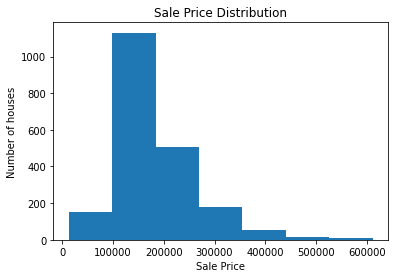

In [18]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(df['saleprice'], bins = 7)
plt.title('Sale Price Distribution')
plt.xlabel('Sale Price')
plt.ylabel('Number of houses')
plt.show()

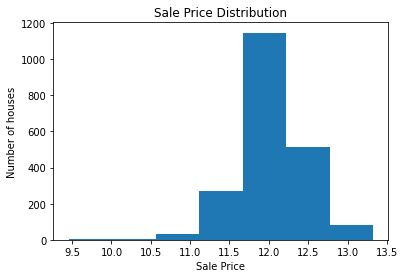

In [19]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(np.log(df['saleprice']), bins = 7)
plt.title('Sale Price Distribution')
plt.xlabel('Sale Price')
plt.ylabel('Number of houses')
plt.show()

The data is right skewed, so we definitely have some outliers with a high Sale Price.  The log Sale Price is skewed as well (to the left, this time), so I want to further investigate the outliers on the actual Sale Price and not use the log.

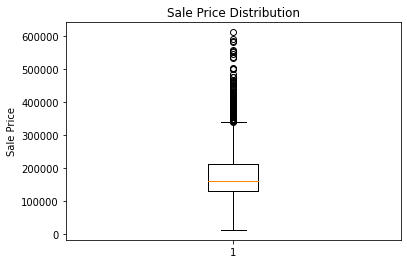

In [20]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.boxplot(df['saleprice'])
plt.title('Sale Price Distribution')
plt.ylabel('Sale Price')
plt.show()

This is definitely eye-opening.  It is worth noting that we made the decision not to delete any rows of data during cleaning, so naturally we see a lot of outliers, but they are highly conglomerated beyond our fourth quartile, which further explains the right skew of the Sale Price distribution graph.  The outlier range is significantly larger than our IQR.  This affirms my decision not to remove outliers because any model without these outliers would likely severely underpredict true values that are larger than 350,000 USD.  While our model might underpredict high Sale Price because of these outliers, the model would be far more inaccurate if the outliers were not included.

In [21]:
df['saleprice'].mean()

181469.70160897123

Now that we better understand the distribution of our target variable, I want to dig into the linear relationship of features vs. the Sale Price.

In [22]:
df.corr()['saleprice'].sort_values().head(20)

mas_vnr_type_None      -0.424088
garage_type_Detchd     -0.370344
foundation_CBlock      -0.355535
lot_shape              -0.294542
ms_zoning_RM           -0.281951
central_air_N          -0.277378
pid                    -0.255052
roof_style_Gable       -0.249329
ms_subclass_30         -0.248534
garage_type_none       -0.230990
foundation_BrkTil      -0.229891
neighborhood_OldTown   -0.208371
house_style_1.5Fin     -0.195803
exterior_1st_Wd Sdng   -0.191734
neighborhood_NAmes     -0.189387
neighborhood_IDOTRR    -0.189237
ms_subclass_50         -0.182336
neighborhood_Edwards   -0.176119
exterior_2nd_Wd Sdng   -0.172971
alley_Grvl             -0.159109
Name: saleprice, dtype: float64

In [23]:
(df.corr()['saleprice'].sort_values(ascending = False).head(20))

saleprice           1.000000
evil_petting_zoo    0.817933
overall_qual        0.800207
sf_t                0.783108
exter_qual          0.712146
gr_liv_area         0.697038
kitchen_qual        0.692336
evil_garage         0.690596
garage_area         0.649897
garage_cars         0.647781
evil_basement       0.640438
evil_mcfly          0.622283
bsmt_qual           0.612188
evil_baths          0.574487
year_built          0.571849
evil_fieri          0.570289
garage_finish       0.557839
year_remod/add      0.550370
fireplace_qu        0.538925
foundation_PConc    0.529047
Name: saleprice, dtype: float64

These two commands show me which features correlate most with linearity, both positive and negative.

We find that Overall Quality is the highest correlated non-engineered feature with Sale Price and Evil Petting Zoo is our highest correlated feature.  I want to investigate that further.  Given that the value was assigned via scale, this will be easier to visualize in a boxplot and scatterplot.
It's also interesting to note that a lot of the engineered features have strong positive correlations relative to other features.

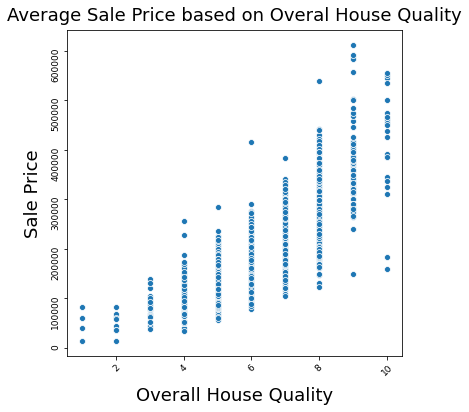

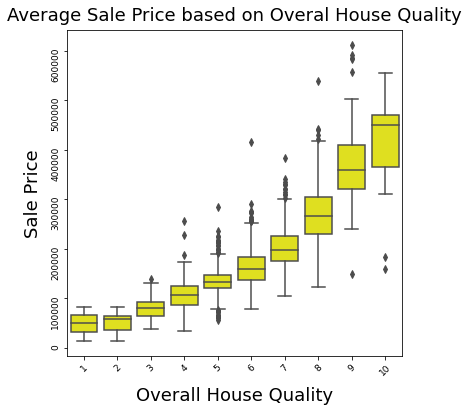

In [24]:
size_var = 18

plt.figure(figsize=(6,6)) # (width, height)
plt.title("Average Sale Price based on Overal House Quality", fontsize = size_var, pad = size_var / 2)

sns.scatterplot(x = df["overall_qual"], y = df["saleprice"], palette = ["yellow"]);

plt.xlabel("Overall House Quality", fontsize = size_var, labelpad = size_var/2)
plt.xticks(fontsize=size_var/2, rotation=45)

plt.ylabel("Sale Price", fontsize = size_var, labelpad = size_var/2)
plt.yticks(fontsize=size_var/2, rotation=90);

size_var = 18

plt.figure(figsize=(6,6)) # (width, height)
plt.title("Average Sale Price based on Overal House Quality", fontsize = size_var, pad = size_var / 2)

sns.boxplot(x = df["overall_qual"], y = df["saleprice"], palette = ["yellow"]);

plt.xlabel("Overall House Quality", fontsize = size_var, labelpad = size_var/2)
plt.xticks(fontsize=size_var/2, rotation=45)

plt.ylabel("Sale Price", fontsize = size_var, labelpad = size_var/2)
plt.yticks(fontsize=size_var/2, rotation=90);

We can clearly see the strong linear relationship between Overall Quality and Sale Price, as our max values and 3rd quartile for Sale Price take on higher values as Overall Quality increases.  This is interesting to note because while quality is subjective to human interpretation since it was collected via an assigned score of 1-10 given by a human, it ends up because our strongest feature.

Sale price has a right skew, with the data peaking around the mean.  While it looked like a fairly normal distribution, the boxplot better shows the significance the outliers will have on any model.  Clearly there are a lot of Sales Price outliers based on Overall Quality, and we would still want to predict those values with our model, which confirms our decision to keep outliers in our training set.  Eliminating these outliers would likely hurt our ability to predict Sale Price.

I now want to take a further look at my strongest engineered feature.

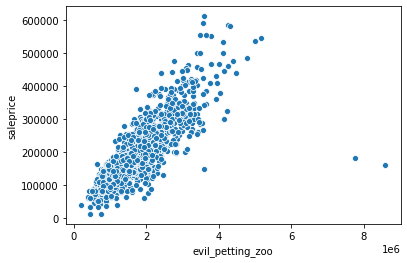

In [25]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
sns.scatterplot(df['evil_petting_zoo'], df['saleprice'])
plt.show;

My highest corrleation of engineered features was the Evil Petting Zoo which interracts the subjective quality features of both the interior and exterior areas (and then Miamified for fun).  We can see on the plot that there is definitely a linear relationship between our engineered feature and Sale Price, with .82 correlation coefficient, indicating a strong, positive linear correlation.  I want to further investigate the two outlier points, though


In [26]:
df.loc[df['evil_petting_zoo'] > 6000000, ['saleprice', 'evil_petting_zoo']]

,saleprice,evil_petting_zoo
960,160000,8604050
1885,183850,7769875


These two rows have the largest amount of "Evil Petting Zoo," but despite the positive linear correlation of the variable, we find that these two points should have much higher Sale Price values.  I tried running a separate model with these outliers dropped, and actually found that the predictive ability of my Linear Model was more accurate with the outliers left in, so I'm keeping them in.

With a better understanding on some of the features that will likely influence my model, I want to start building a model and further evaluate features that can improve its predictive power.

## Model Preparation

In [27]:
# drops y, numerical features that don't explain y, and sale type 
X = df.drop(columns = ['saleprice', 'pid', 'id', 'sale_type'])
y = df["saleprice"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = RANDOM_STATE)

Since RMSE is the metric we'll use to measure success, I want to use a function to help automate that step.  We are choosing RMSE because it measures in the same unit as our y value (USD).  RMSE can be easily interpreted as the average error in dollar amount, which tells us the most when predicting prices.

In [28]:
def rmse(y_true, y_pred): # Mahdi's RMSE calculator
    '''Returns the root mean squared error'''
    return np.sqrt(mean_squared_error(y_true, y_pred))


## Modeling

### Baseline Model

In [29]:
base_preds = [y_train.mean() for _ in y_train]

In [30]:
y_train.mean() 

182635.06046814044

Baseline model is equivalent to guessing the mean every single time.

In [31]:
base_rmse = rmse(y_train, base_preds)
base_rmse

79841.53874104604

Baseline model is well outside of 50,000 USD target range.  Since we are predicting a target using regression, I will start by building a Linear Model.

### Linear Regression

In [32]:
# instantiate
lr = LinearRegression()

# fit
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [33]:
y_train_preds = lr.predict(X_train) #generate training predictions

In [34]:
y_test_preds = lr.predict(X_test) #generate test predictions

In [35]:
lr_train_rmse = rmse(y_train, y_train_preds)
lr_train_rmse

31191.54084922374

In [36]:
lr_test_rmse = rmse(y_test, y_test_preds)
lr_test_rmse

27776.93691880493

In [37]:
lr_cv = cross_val_score(lr, X, y, cv = 5, scoring = make_scorer(rmse)).mean() # From Mahdi's FAQ
lr_cv

30543.34031554545

The Linear Regression model is an improvement from the Baseline Model, based on a significant decrease in RMSE.  A higher cross-validation RMSE compared to our test RMSE signifies that the model may not perform as well against new data as we might originally think.  My next inclination is to try a Ridge Regression Model and also a Lasso Regression Model afterwards to further evaluate which features are and aren't meaningfully contributing to our model's predictions.


### Ridge

Since our model deals with both dummies and non-dummies as numerical features, I need to scale my data appropriately.

In [38]:
ss = StandardScaler()
# Scale data for Ridge and Lasso models
ss.fit(X_train)

Z_train = ss.transform(X_train)
Z_test = ss.transform(X_test)

In [39]:
# Instantiate.
ridge_model = RidgeCV(alphas=np.logspace(-6, 6, 100))

# Fit.
ridge_model.fit(Z_train, y_train)

#find best alpha value in logspace range
ridge_model.alpha_

# Re-instantiate with best alpha value
ridge_model = Ridge(alpha=ridge_model.alpha_)

# Re-fit with best alpha value
ridge_model.fit(Z_train, y_train)


Ridge(alpha=932.6033468832219, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [40]:
Z_train_preds = ridge_model.predict(Z_train)

In [41]:
Z_test_preds = ridge_model.predict(Z_test)

In [42]:
ridge_train_rmse = rmse(y_train, Z_train_preds)
ridge_train_rmse

24129.729659814122

In [43]:
ridge_test_rmse = rmse(y_test, Z_test_preds)
ridge_test_rmse

23179.839237623175

In [44]:
ridge_model_cv = cross_val_score(ridge_model, X, y, cv = 5, scoring = make_scorer(rmse)).mean() # From Mahdi's FAQ
ridge_model_cv

26840.46591180002

The Ridge Model is a more significant improvement from the Baseline Model than the Linear Model based on a greater decrease in training and testing RMSE.  We are still seeing a higher cross validation score than testing score, so this model also may not perform as well against new data as we might originally think.   While this is helpful and definitely an improvement over the original Linear Model, I want to see if the Lasso Model scores better, so I can decide which coefficients to further investigate.

### Lasso

In [45]:
# Instantiate.
lasso_model = LassoCV(alphas=np.logspace(-6, 6, 100))

# Fit.
lasso_model.fit(Z_train, y_train)

# will automatically find my best alpha
lasso_model.alpha_

# Re-instantiate with best alpha value
lasso_model = Lasso(alpha=lasso_model.alpha_)

# Re-fit with best alpha value
lasso_model.fit(Z_train, y_train)


Lasso(alpha=932.6033468832219, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [46]:
Z_train_preds_l = lasso_model.predict(Z_train)

Z_test_preds_l = lasso_model.predict(Z_test)

print(mean_squared_error(y_true = y_train, y_pred=Z_train_preds_l)**0.5)

print(mean_squared_error(y_true = y_test, y_pred=Z_test_preds_l)**0.5)

21422.05232794101
21016.71558642051


In [47]:
lasso_train_rmse = rmse(y_train, Z_train_preds_l)
lasso_train_rmse

21422.05232794101

In [48]:
lasso_test_rmse = rmse(y_test, Z_test_preds_l)
lasso_test_rmse

21016.71558642051

In [49]:
lasso_model_cv = cross_val_score(lasso_model, X, y, cv = 5, scoring = make_scorer(rmse)).mean() # From Mahdi's FAQ
lasso_model_cv

27042.199968547786

The Lasso Model is still a significant improvement from the Baseline Model than the Linear Model based on a greater decrease in training and testing RMSE.  While the Ridge Model had a better cross validation score than the Lasso Model, I'm inclined to say that the lower training and testing RMSE for the Lasso Model is my preferred choice over the Ridge Model.  I'm going to further investigate the coefficients of the Lasso Model and identify which features should be removed before attempting another Linear Regression.

In [50]:
coef_df_lasso = pd.DataFrame({'col_name': X.columns, 'coef': lasso_model.coef_,
                       'abs': np.abs(lasso_model.coef_)})

coef_df_lasso.sort_values('coef', ascending=False).head(10)


,col_name,coef,abs
231,evil_petting_zoo,28811.177578,28811.177578
228,evil_basement,10515.778140,10515.778140
3,overall_qual,10472.978712,10472.978712
14,bsmtfin_sf_1,7475.319511,7475.319511
223,sf_t,7216.740863,7216.740863
117,neighborhood_StoneBr,5916.910222,5916.910222
229,evil_mcfly,5732.971551,5732.971551
111,neighborhood_NridgHt,5339.854955,5339.854955
224,evil_garage,4985.347003,4985.347003
230,evil_fieri,4553.279981,4553.279981


This shows me the top 10 positive coefficients, indicating which features have the greatest positive affect on my model.

In [51]:
coef_df_lasso.sort_values('coef', ascending=False).tail(10)

,col_name,coef,abs
87,lot_config_FR3,-351.918884,351.918884
125,condition_1_RRAe,-376.912594,376.912594
164,exterior_1st_BrkComm,-390.361992,390.361992
115,neighborhood_SawyerW,-498.209569,498.209569
71,ms_zoning_RM,-838.289984,838.289984
120,condition_1_Artery,-899.895149,899.895149
183,exterior_2nd_HdBoard,-938.978910,938.978910
154,roof_style_Mansard,-2357.209648,2357.209648
217,misc_feature_Elev,-14813.219610,14813.219610
156,roof_matl_ClyTile,-18825.989815,18825.989815


This shows me the top 10 negative coefficients, indicating which features have the greatest negative affect on my model.
The absolute value calculations are to showcase the magnitude because negative coefficients have the exact same magnitude as positive coefficients, but rather showcase features that would determine a decrease in our y (Sale Price). 


### Improved Linear Regression By Eliminating Zero Coefficients

Our Lasso Model revealed a lot of coeficients of 0, meaning that we had a lot of features that were identified as not having an impact at all.  These same features were likely throwing off the predictive ability of our original Linear Model.  I want to run a Linear Model again, but this time without the "disruptive" features.

In [52]:
good_coefs = coef_df_lasso.loc[coef_df_lasso['coef'] != 0]
good_coefs

,col_name,coef,abs
0,lot_frontage,823.632380,823.632380
1,lot_area,3027.239792,3027.239792
3,overall_qual,10472.978712,10472.978712
4,overall_cond,3159.987564,3159.987564
5,year_built,1703.800448,1703.800448
...,...,...,...
225,evil_baths,327.188650,327.188650
228,evil_basement,10515.778140,10515.778140
229,evil_mcfly,5732.971551,5732.971551
230,evil_fieri,4553.279981,4553.279981


In [53]:
X = df[good_coefs['col_name'].values]
y = df['saleprice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = RANDOM_STATE)

Changed my X to only contain the features identified by my Lasso Model and ran a train, test, split.

In [54]:
lr = LinearRegression() # instantiate

In [55]:
lr.fit(X_train, y_train) # fit

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [56]:
train_preds = lr.predict(X_train)

In [57]:
test_preds = lr.predict(X_test)

In [58]:
lr2_train_rmse = rmse(y_train, train_preds)
lr2_train_rmse

20577.430881443397

In [59]:
lr2_test_rmse = rmse(y_test, test_preds)
lr2_test_rmse

21413.384879158173

In [60]:
lr2_cv = cross_val_score(lr, X, y, cv = 5, scoring = make_scorer(rmse)).mean() # From Mahdi's FAQ
lr2_cv

29710.163580960525

This was the best performing model compared the Baseline and all other models based on having the lowest training and testing RMSE.  Additionally, it had the smallest difference between training and testing RMSE, meaning that this is our best fit model.

## Model Selection

In [61]:
print(f'RMSE for our Baseline model is: {round(base_rmse, 2)}.')

print(f'Training RMSE for our Linear Regression model is: {round(lr_train_rmse, 2)}.')
print(f'Testing RMSE for our Linear Regression model is: {round(lr_test_rmse, 2)}.')
print(f'Training RMSE for our Ridge model is: {round(ridge_train_rmse, 2)}.')
print(f'Testing RMSE for our Ridge model is: {round(ridge_test_rmse, 2)}.')
print(f'Training RMSE for our Lasso model is: {round(lasso_train_rmse, 2)}.')
print(f'Testing RMSE for our Lasso model is: {round(lasso_test_rmse, 2)}.')
print(f'Training RMSE for our Final Linear Regression model is: {round(lr2_train_rmse, 2)}.')
print(f'Testing RMSE for our Final Linear Regression model is: {round(lr2_test_rmse, 2)}.')


RMSE for our Baseline model is: 79841.54.
Training RMSE for our Linear Regression model is: 31191.54.
Testing RMSE for our Linear Regression model is: 27776.94.
Training RMSE for our Ridge model is: 24129.73.
Testing RMSE for our Ridge model is: 23179.84.
Training RMSE for our Lasso model is: 21422.05.
Testing RMSE for our Lasso model is: 21016.72.
Training RMSE for our Final Linear Regression model is: 20577.43.
Testing RMSE for our Final Linear Regression model is: 21413.38.


After running all of these models, I am selecting the Linear Model as our interpretive model and the Lasso Model as our predictive model.  While the Lasso Model had the lowest testing RMSE, the difference between the Lasso Model and Linear Model on testing RMSE is close enough and the training RMSE is actually lower on the Linear Model.

## Model Evaluation

Since our Linear Regression is our interpretive model, thanks to the assistance of the Lasso Model, let's dive deeper into what made the model successful by looking at the coefficients.

In [62]:
lr2_coefs = pd.DataFrame({'col_name': X.columns, 'coef': lr.coef_,
                       'abs': np.abs(lr.coef_)})
round(lr2_coefs.sort_values('coef', ascending = False), 2).head(33)

,col_name,coef,abs
29,neighborhood_GrnHill,112419.04,112419.04
47,roof_matl_WdShngl,73518.40,73518.40
35,neighborhood_StoneBr,49221.49,49221.49
31,neighborhood_NridgHt,27505.32,27505.32
38,condition_1_PosA,19443.22,19443.22
27,neighborhood_Crawfor,17539.46,17539.46
30,neighborhood_NoRidge,15757.94,15757.94
49,exterior_1st_BrkFace,14198.50,14198.50
43,house_style_2.5Fin,12214.35,12214.35
41,bldg_type_1Fam,10776.21,10776.21


Shows the highest positive correlations.

In [63]:
round(lr2_coefs.sort_values('coef', ascending = False), 2).tail(33)

,col_name,coef,abs
17,screen_porch,49.48,49.48
6,bsmtfin_sf_1,17.11,17.11
5,mas_vnr_area,16.71,16.71
16,open_porch_sf,12.21,12.21
59,sf_t,7.22,7.22
15,wood_deck_sf,6.53,6.53
60,evil_garage,6.19,6.19
62,evil_basement,1.29,1.29
1,lot_area,0.50,0.50
64,evil_fieri,0.05,0.05


Shows the lowest positive and highest negative correlations

This was very interesting to see!  While the correlation evaluation in EDA showed engineered features to have a stronger correlation with Sale Price and neighborhoods not factoring in that much, the coefficients in our Linear Regression say otherwise.  For example, a house in the Green Hills neighborhood automatically would be worth 112419.04 USD more than a house not in Green Hills if all other variables are held constant.  While Overall Quality still plays a part in our Linear Regression, a one unit increase in Overall Quality results in a 5698.47 USD increase in Sale Price.  Now I want to check my residuals to ensure that my Linear Model is appropriately meeting the criterion of residual independence & homoscedasticity.

In [64]:
resids = y_test - test_preds #calculate residuals

In [65]:
''' From Madhi's linear regression lesson, this is a function to plot predictions v. actual for
   both training and testing data'''
def plot_predictions(model_name, y_train_pred, y_test_pred, y_train_actual, y_test_actual):
    sns.scatterplot(y_train_pred, y_train_actual, label = "Training data", color = "green", alpha = .8)
    sns.scatterplot(y_test_pred, y_test_actual, label = "Testing data", color = "red", alpha = .3) # made red more transparent since it covers up some green
    plt.title(model_name+"Regression Accuracy (Colorblinded for Maximum Evilness)")
    plt.xlabel("Evil Prediction Price (in USD)")
    plt.ylabel("Actual Sale Price (in USD)")
    plt.legend(loc = "upper left")
    all_vals = np.concatenate([y_train_pred, y_test_pred, y_train_actual, y_test_actual])
    the_max_val = np.max(all_vals)
    the_min_val = np.min(all_vals)
    plt.plot([the_min_val, the_max_val],[the_min_val, the_max_val], c='black')
    plt.tight_layout()



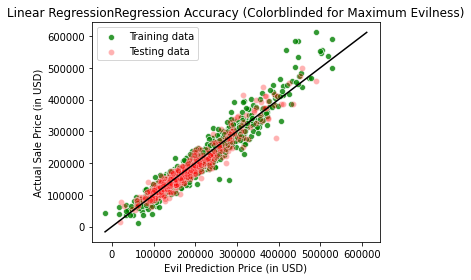

In [66]:
plot_predictions(model_name = "Linear Regression",
                 y_train_pred = train_preds,
                 y_test_pred = test_preds,
                 y_train_actual = y_train,
                 y_test_actual = y_test);

This graph does help visualize that the model actually performs better with the testing data than training data.  It appears that the errors seem to fall in the same range.  The training data does show that the model was underpredicting by a higher margin as the price increased.  We start to see that trend for the testing data, so it is possible that if housing values went up significantly in Ames, we might have to build a different model off more current data.  Keep in mind that all of our Sale Price outliers were for the more expensive properties.

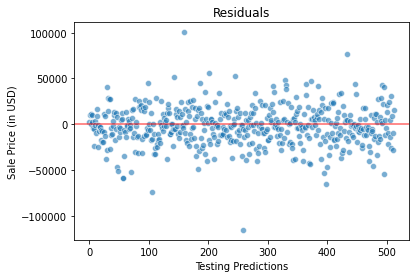

In [67]:
# Based on Chris Kuzemka's residual plot
plt.figure() #sets figure size
plt.axhline(0, c = "r", alpha = .6) #sets the opacity and color red for the line
sns.scatterplot(x = range(len(resids)),y = resids, alpha = .6) #sets the opacity and plots a scatter plot
plt.title('Residuals') #
plt.xlabel('Testing Predictions')
plt.ylabel('Sale Price (in USD)');


This residual plot shows that our errors do meet the criteria of being homoscedastic (approximately within the same range throughout all of our predictions).  We do see one outlies that severly underpredicts as well as one or two that greatly underpredict.

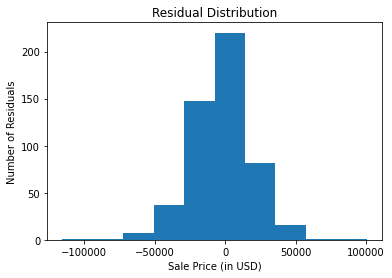

In [68]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(resids, bins = 10)
plt.title('Residual Distribution')
plt.xlabel('Sale Price (in USD)')
plt.ylabel('Number of Residuals')
plt.show();

Our residuals do follow an approximately normal distribution, peaking at 0.  I am satisfied with this model and that it fulfills the requirements of a Linear Model.

## Conclusion

Considering our goal was to predict within 50,000 USD of the actual sale price, we have been able to meet that goal.  Our Linear Regression Model that we created after inspecting the coefficients of our Lasso Model was our best choice based on the lowest RMSE score, which was our chosen success metric to begin this project.

Based on Dr. Evil's budgetary constraints and due to the greater residuals as price increased, my recommendation would be to be conscious of what areas to buy in order to build an evil lair.  Since world domination is the ultimate goal, neighborhood shouldn't matter all that much, and we could save a lot of money for more evil contraptions.

### Recommendations

This model can be used specifically for Dr. Evil to pay fair value with little hassle.  Additionally, if being an Evil Doctor somehow fails again, Dr. Evil can use this model to go into real estate, which would require little sacrifice on the evil side of things.

### Future Steps

For future modifications, I would like to further investigate the frequency of a feature within my dummy columns vs the coefficients in my model.  For example, there is only one house with a clay tile roof, but it is one of my strongest negative coefficients.  That doesn't aspire a lot of confidence if my model had to predict the price of another house with a clay tile roof.  This further investigation could help me better predict outlier values or allow me to remove more outliers altogether.  I might also want to rerun the Lasso and Ridge models to even better fine tune my Linear Regression.  Lastly, I have a lot of fun feature engineering, and while it didn't factor too strongly in my Linear Regression, perhaps some more creative feature engineering would be able to achieve that.

## References
http://jse.amstat.org/v19n3/decock/DataDocumentation.txt

A lot of references to the Austin Powers movies.

## Kaggle Submission

WHATEVER we did to the first dataset, we MUST do to the validation/hold-out set

In [69]:
#missing_cols = ['exterior_2nd_Stone', 'exterior_1st_ImStucc', 'condition_2_RRNn', 'ms_subclass_150', 'utilities_3', 'heating_OthW', 'roof_matl_Membran', 'neighborhood_GrnHill', 'misc_feature_TenC', 'utilities_NoSeWa', 'ms_zoning_A (agr)', 'neighborhood_Landmrk', 'condition_2_Artery', 'land_slope_2', 'exterior_1st_CBlock', 'misc_feature_Elev', 'condition_2_RRAe', 'heating_Wall', 'land_slope_1', 'condition_2_PosN', 'roof_matl_ClyTile', 'exterior_1st_Stone', 'condition_2_RRAn']

In [70]:
#for col in missing_cols:
   # test_df[col] = 0

In [71]:
#val = test_df[X_train.columns]

In [72]:
#val_sc = ss.transform(val)

In [73]:
#preds = lasso_model.predict(val_sc)

In [74]:
# We need to submit to Kaggle in the appropriate form of .csv
# create prediction Series
#preds_col = pd.Series(preds, name = "SalePrice")
# combine with Id
#id_col    = test_df["id"]
#output = pd.concat([id_col, preds_col], axis = 1)
#output.columns = ['Id', 'SalePrice']
#output.head()

In [75]:
# write to csv

#output.to_csv('../output/submission.csv', index = False)